In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -1.491462 -0.906444  0.495217  0.307952  0.655188  0.401626 -0.920272   
  1   0.930736  0.463232  0.602409 -0.079844  0.343861 -0.133679  0.790112   
  2   0.057347 -1.234720 -0.319068 -0.895484 -0.131205  0.611766 -0.261250   
  3  -0.369577 -0.109764 -0.569378  0.027618 -0.206888  0.039778 -0.073484   
  4  -0.101792 -0.702712  0.714525 -0.101127 -0.009115 -1.308703 -1.301776   
  5   0.150897  0.202042 -0.350758 -0.586631  0.309026 -0.426431 -0.329117   
  6  -0.800333  0.770660  0.462063 -0.227168  0.139518 -0.181876 -1.024037   
  7   0.163949 -0.071370 -0.940954  0.862910  0.482188  0.077433 -0.339661   
  8   0.036394  0.286482 -0.210158 -0.289491 -0.671360  0.479284 -0.457388   
  9   0.229961  0.326234 -0.373553  0.142140  1.021400  0.208839 -0.194214   
  10  1.050480  0.070622  0.357668  0.628954 -0.002855 -0.383632 -0.345271   
  11  0.559066  0.264412  0.032079  0.873178  1.410179  0.178110  0.856391   
  12 -0.241250  0.707098  0.595648 -0.156041  1.120219 -0.669950 -0.277353   
  13  0.017729  0.852195 -0.139044 -0.448784  0.387244 -0.336289 -0.125215   
  14  0.231670  0.738840  0.044887 -0.327311 -0.124638 -1.732546 -0.829625   
  15  0.427989  1.174474  0.883872 -0.238489 -1.312301 -0.857274 -0.712994   
  16  1.260833  0.674043  0.825535  0.839903  0.342742  0.153463  0.538627   
  17 -0.319809 -0.254860  0.258442 -0.255817 -0.568477 -0.485859 -0.224952   
  18  0.707663  0.097329 -0.104934  0.367824  0.565734 -1.226605 -0.436415   
  19  0.695764  0.659746  0.523368 -0.579406 -0.030759 -0.215211 -0.269550   
  20 -0.198488  0.115867  0.665352 -0.514816 -1.144404 -0.794454 -0.588228   
  21 -0.028772  0.530032 -0.674247 -0.406166  0.158302 -1.081993 -0.462067   
  22 -1.541828 -1.608938 -0.390793 -0.772627 -0.640035 -0.365326 -0.628317   
  23  0.049898  0.592936  0.389265  0.020053  0.921646  0.081183 -0.216495   
  24 -0.486387 -0.216157 -0.585835 -0.487170  0.634947 -0.095250  0.429593   
1 0   0.148365 -0.583558  0.405164 -0.417763 -0.579117  0.166136 -0.707339   
  1   1.175414 -0.115417 -1.631242  0.475087  0.975915  1.089403  2.008777   
  2   0.397593 -0.310145 -0.585321  0.202523 -0.068990  0.083473  0.601209   
  3   0.100320  0.629820 -0.952504 -0.018761 -0.216204 -0.672178  0.564566   
  4   0.529842 -0.125635 -0.477340 -0.250212  0.689732 -0.520595 -0.377703   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.229110 -0.455008  0.147187  ...  0.421169  0.275399 -0.249505   
  1   0.383203  0.170836  0.649549  ... -0.362711 -0.544353 -0.290546   
  2   0.068351 -0.253619 -0.812223  ... -0.040202  1.174134 -0.841283   
  3  -0.397489  0.376929  0.314002  ... -0.452669  0.449893 -1.474639   
  4  -0.474284  0.469781  0.006131  ...  0.413068  0.320934  0.064627   
  5  -1.335770 -0.818859  0.329591  ...  0.129024  0.713424 -0.038198   
  6  -0.052974  0.246047  0.169236  ...  0.741685  0.236800 -0.054774   
  7  -0.109753  0.704038  0.403296  ...  0.168168  1.009816  0.146498   
  8  -0.118826 -0.341591 -0.533793  ...  0.365686  0.846074  0.569181   
  9   0.834981  0.515110  0.808086  ...  0.636130  0.488256  0.557436   
  10  0.500386  0.994559  0.972942  ... -0.665499  0.246735 -0.256550   
  11  1.142033 -0.059681  0.188208  ...  0.419945  0.931538  0.819811   
  12  1.651751  1.625567  0.089182  ...  0.234850 -0.546348 -0.746529   
  13  0.501872  0.365118  0.649419  ... -0.191775 -0.005826  0.537028   
  14  0.328395  0.928387  1.047507  ... -0.305834  0.159695  0.115740   
  15  0.673484 -0.030372  0.768230  ... -0.353357  0.378798 -0.225906   
  16  0.990490  0.344783  1.009500  ... -0.125990  0.092005  1.750282   
  17  0.805353  0.576212  0.513742  ... -0.266195 -0.059138 -0.191042   
  18  1.226239  0.867690  0.907531  ... -0.005529 -0.968030 -0.933093   
  19 -0.111208 -0.023804  0.027343  ... -0.022153 -0.340454 -0.297891   
  20 -0.000390  0.241530  1.049597  ... -0.499716  0.647045 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.088634  0.049517  21.985112  3.998078e-107  0.991583  1.185685


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



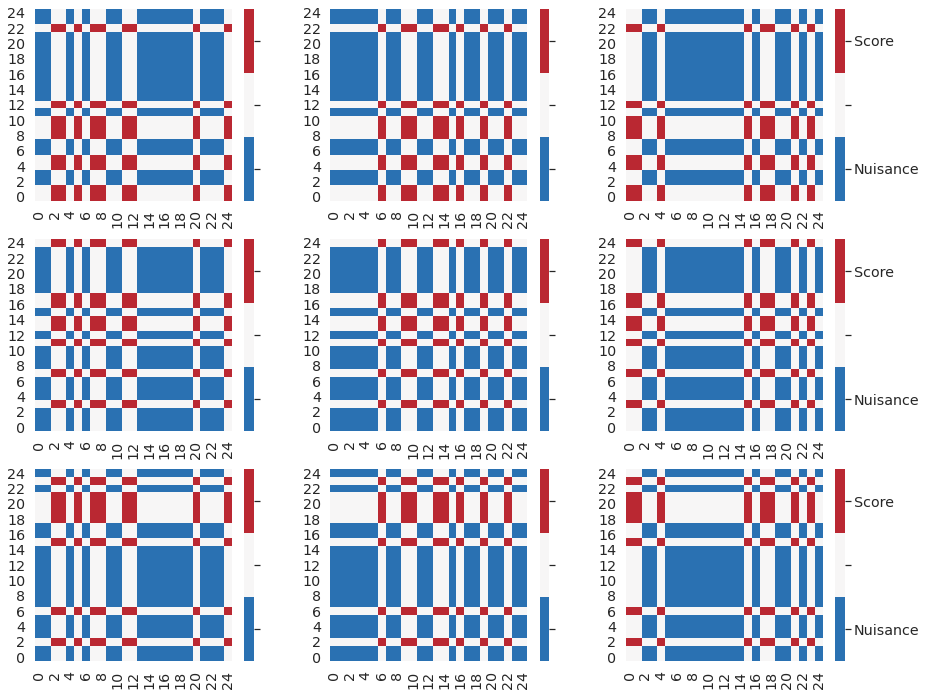

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



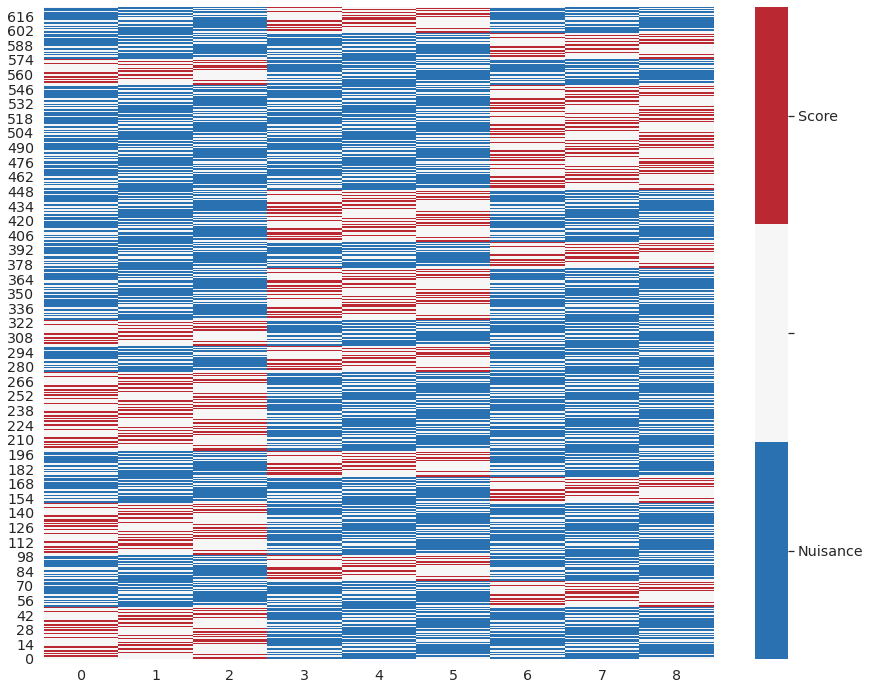

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])